In [1]:
# https://github.com/mrhuke/GMM-adaptation
# https://github.com/scelesticsiva/speaker_recognition_GMM_UBM/blob/master/src/speaker_recognition/MAP_adapt.py

from sklearn.mixture import GaussianMixture
import numpy as np
import itertools
import pylab as pl
import matplotlib as mpl
from scipy import linalg
from matplotlib.patches import Ellipse

In [2]:
def plotgmm(gmm,X, pl_title):
    color_iter = itertools.cycle(['r', 'g', 'b', 'c', 'm'])

    for i, (clf, title) in enumerate([(gmm, pl_title)]):
        splot = pl.subplot(1, 1, 1 + i)
        Y_ = clf.predict(X)
        for i, (mean, covar, color) in enumerate(zip(
                clf.means_, clf.covariances_, color_iter)):
            # as the DP will not use every component it has access to
            # unless it needs it, we shouldn't plot the redundant
            # components.
            if covar.shape == (2, 2):
                v, w = linalg.eigh(covar)
                u = w[0] / linalg.norm(w[0])
                angle = np.arctan(u[1] / u[0])
            else:
                v=covar
                angle = np.arctan(1)
            # print ('eigen value', v)
            
            if not np.any(Y_ == i):
                continue
            pl.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)

            # Plot an ellipse to show the Gaussian component
            angle = 180 * angle / np.pi  # convert to degrees
            ell = mpl.patches.Ellipse(mean, v[0], v[1], 180 + angle, color=color)
            #ell.set_clip_box(splot.bbox)
            ell.set_alpha(0.5)
            splot.add_artist(ell)

    pl.xlim(-10, 10)
    pl.ylim(-10, 10)
    pl.xticks(())
    pl.yticks(())
    pl.title(title)

    pl.show()

In [3]:
def map_adaptation(gmm, data, max_iterations = 10, likelihood_threshold = 1e-20, relevance_factor = 16):
    N = data.shape[0]
    D = data.shape[1]
    K = gmm.n_components
    
    mu_new = np.zeros((K,D))
    n_k = np.zeros((K,1))
    
    mu_k = gmm.means_
    cov_k = gmm.covariances_
    pi_k = gmm.weights_

    old_likelihood = gmm.score(data)
    new_likelihood = 0
    iterations = 0
    while(abs(old_likelihood - new_likelihood) > likelihood_threshold and iterations < max_iterations):
        iterations += 1
        old_likelihood = new_likelihood
        z_n_k = gmm.predict_proba(data)
        n_k = np.sum(z_n_k,axis = 0)

        for i in range(K):
            temp = np.zeros((1,D))
            for n in range(N):
                temp += z_n_k[n][i]*data[n,:]
            mu_new[i] = (1/n_k[i])*temp

        adaptation_coefficient = n_k/(n_k + relevance_factor)
        for k in range(K):
            mu_k[k] = (adaptation_coefficient[k] * mu_new[k]) + ((1 - adaptation_coefficient[k]) * mu_k[k])
        gmm.means_ = mu_k

        log_likelihood = gmm.score(data)
        new_likelihood = log_likelihood
        print(log_likelihood)
    return gmm

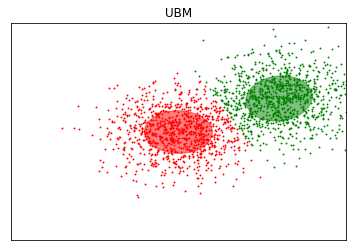

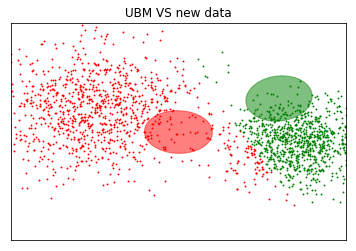

-5.5571200572047985
-5.438967764365922
-5.437858516393817
-5.437840160496984
-5.437839840528481
-5.437839834925944
-5.437839834827797
-5.437839834826079
-5.437839834826049
-5.437839834826048


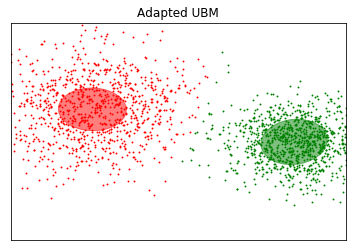

In [4]:
n_samples = 1000

# np.random.seed(0)

X = np.r_[np.random.randn(n_samples,2)*2, np.random.randn(n_samples,2)*2+np.array([6,3])]
Y = np.r_[np.random.randn(n_samples,2)*3+np.array([-5,2]), np.random.randn(n_samples,2)*2+np.array([7,-1])]

# Fit a mixture of gaussians with EM using five components
gmm = GaussianMixture(n_components=2, covariance_type='full')
gmm.fit(X)

plotgmm(gmm, X, 'UBM')
plotgmm(gmm, Y, 'UBM VS new data')

# QB map adaptation
gmm = map_adaptation(gmm, Y, max_iterations=10, relevance_factor=16)
plotgmm(gmm, Y, 'Adapted UBM')